## Objetivo do Trabalho

O objetivo desse trabalho é retornar a classe correta de um pokemon tendo como entrada a foto desse pokemon.

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from shutil import copy2, rmtree
from PIL import Image
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

## Lendo o Dataset

In [70]:
pokemon_df = pd.read_csv('pokemon.csv')
pokemon_df.Type1.value_counts()

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Type1, dtype: int64

Como vemos acima, temos 18 classes de Pokemon (considerando apenas o Tipo Primário do monstro). Nota-se que há tipos com muitas poucas amostras, o que dificultaria bastante sua predição correta. Para tentarmos melhorar, escolhemos dividir as amostras em 4 classes: Água, Fogo, Normal e Outros. Quando um pokemon possui dois dos tipos (por exemplo, Type1 = Water e Type2 = Normal), fazemos sua inclusão na classe referente ao seu tipo primário.

In [3]:
pokemon_water = pokemon_df.loc[((pokemon_df.Type1 != "Fire") 
                               & (pokemon_df.Type1 != "Normal") 
                               & (pokemon_df.Type2 == "Water")) | (pokemon_df.Type1 == "Water")].copy()

pokemon_fire = pokemon_df.loc[((pokemon_df.Type1 != "Water") 
                               & (pokemon_df.Type1 != "Normal") 
                               & (pokemon_df.Type2 == "Fire")) | (pokemon_df.Type1 == "Fire")].copy()

pokemon_normal = pokemon_df.loc[((pokemon_df.Type1 != "Fire") 
                               & (pokemon_df.Type1 != "Water") 
                               & (pokemon_df.Type2 == "Normal")) | (pokemon_df.Type1 == "Normal")].copy()

pokemon_other = pokemon_df.loc[(pokemon_df.Type1 != "Fire") 
                               & (pokemon_df.Type1 != "Water") 
                               & (pokemon_df.Type1 != "Normal")
                               & (pokemon_df.Type2 != "Fire") 
                               & (pokemon_df.Type2 != "Water") 
                               & (pokemon_df.Type2 != "Normal")].copy()

In [4]:
pk_dict = {"Name" : [], 
           "Type" : []}

for pk_name in pokemon_water.Name.values:
    pk_dict["Name"].append(pk_name)
    pk_dict["Type"].append("Water")
    
for pk_name in pokemon_fire.Name.values:
    pk_dict["Name"].append(pk_name)
    pk_dict["Type"].append("Fire")
    
for pk_name in pokemon_normal.Name.values:
    pk_dict["Name"].append(pk_name)
    pk_dict["Type"].append("Normal")

for pk_name in pokemon_other.Name.values:
    pk_dict["Name"].append(pk_name)
    pk_dict["Type"].append("Others")

In [5]:
pk_types_df = pd.DataFrame(pk_dict)
pk_types_df

,Name,Type
0,squirtle,Water
1,wartortle,Water
2,blastoise,Water
3,psyduck,Water
4,golduck,Water
...,...,...
804,naganadel,Others
805,stakataka,Others
806,zeraora,Others
807,meltan,Others


Vemos agora que as classes ficaram com mais amostras, mesmos que Others ainda se sobressaia.

In [8]:
pk_types_df['Type'].value_counts()

Others    509
Water     129
Normal    107
Fire       64
Name: Type, dtype: int64

### Adicionando path da imagem na row correspondente

Algumas imagens possuem fundo transparente, então incluimos nelas um fundo branco e as transformamos de PNG para JPG. É importante notar que, quando a pasta já existe, a excluímos e a criamos de novo. Isso pode ser feito apenas uma vez, mas deixamos para manter esse passo de conversão no notebook.

In [6]:
pokemon_imgs = os.listdir('images')

if not os.path.exists('converted_images/'):
    os.mkdir('converted_images/')
else:
    rmtree('converted_images/')
    os.mkdir('converted_images/') 

sorted_imgs = pokemon_imgs.copy()
for pokemon in pokemon_imgs:
    pk_img = Image.open(f'images/{pokemon}')
    
    pk_img = pk_img.convert("RGBA")
    background = background = Image.new('RGB', pk_img.size, (256,256,256))
    background.paste(pk_img, mask=pk_img.split()[3])
    
    background.save(f'converted_images/{pokemon.split(".")[0]}.jpg')
    
    pokemon_name = pokemon.split('.')[0]
    index = pokemon_df[pk_types_df.Name == pokemon_name].index.values[0]
    sorted_imgs[index] = f'{pokemon.split(".")[0]}.jpg'

Fazemos a ligação correta entre o caminho da imagem de um pokemon e sua posição na tabela de classes.

In [7]:
pk_types_df['Pokemon Image'] = sorted_imgs
pk_types_df

,Name,Type,Pokemon Image
0,squirtle,Water,squirtle.jpg
1,wartortle,Water,wartortle.jpg
2,blastoise,Water,blastoise.jpg
3,psyduck,Water,psyduck.jpg
4,golduck,Water,golduck.jpg
...,...,...,...
804,naganadel,Others,naganadel.jpg
805,stakataka,Others,stakataka.jpg
806,zeraora,Others,zeraora.jpg
807,meltan,Others,meltan.jpg


### Separando imagens em Treino, Validação e Teste

Nesse passo, fazemos a divisão das imagens para treino, validação e teste. Primeiro fazemos a divisão 0.8/0.2 entre treino e teste. Depois, fazemos outra divisão 0.8/0.2, mas dessa vez pra dividir os dados de treino, gerados no primeiro split, entre dados de treino e dados de validação.

In [9]:
if not os.path.exists('train/'):
    os.mkdir('train/')
else:
    rmtree('train/')
    os.mkdir('train/') 

if not os.path.exists('val/'):
    os.mkdir('val/')
else:
    rmtree('val/')
    os.mkdir('val/') 

if not os.path.exists('test/'):
    os.mkdir('test/')
else:
    rmtree('test/')
    os.mkdir('test/') 

In [10]:
for pk_type in pk_types_df.Type.unique():
    if not os.path.exists(f'train/{pk_type}/'):
        os.mkdir('train/'+str(pk_type)+'/')
    if not os.path.exists(f'val/{pk_type}/'):
        os.mkdir('val/'+str(pk_type)+'/')
    if not os.path.exists(f'test/'):
        os.mkdir('test/')

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(pk_types_df['Pokemon Image'], pk_types_df.Type, 
                                                    test_size=0.2, stratify=pk_types_df.Type, random_state=42)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=0.2, stratify=y_train_val, random_state=42)

In [13]:
for from_path, to_path in zip(X_train.values, y_train.values):
    if os.path.exists( f'train/{to_path}'):
        copy2(f'converted_images/{from_path}', f'train/{to_path}/')
    

In [14]:
for from_path, to_path in zip(X_test.values, y_test.values):
    copy2(f'converted_images/{from_path}', f'test/')

In [15]:
for from_path, to_path in zip(X_val.values, y_val.values):
    if os.path.exists( f'val/{to_path}'):
        copy2(f'converted_images/{from_path}', f'val/{to_path}/')

## Data Augmentation

Devido à baixa quantidade de amostras do dataset (809 amostras), utilizamos o método ImageDataGenerator para fazer Data Augmentation em tempo real. Mais detalhes sobre o método em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#methods

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory('train/', 
                                                    target_size = (64, 64), 
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    color_mode='rgb')

val_generator = val_datagen.flow_from_directory('val/', 
                                                  target_size = (64, 64),
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 517 images belonging to 4 classes.
Found 130 images belonging to 4 classes.


## Testando CNNs

Testamos uma Rede Neural Convolucional com apenas duas camadas de Convolução, com ReLu como retificador, e cada uma dessas camadas seguidas por uma camada de MaxPooling. Além disso, incluímos Dropouts, Flatten e duas camadas densas.

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [20]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
model.fit(train_generator,
          epochs = 30,
          validation_data = val_generator);

Epoch 1/30
17/17 [==============================] - 2s 117ms/step - loss: 0.8898 - accuracy: 0.6460 - val_loss: 0.9276 - val_accuracy: 0.6769
Epoch 2/30
17/17 [==============================] - 2s 128ms/step - loss: 0.8885 - accuracy: 0.6557 - val_loss: 0.9007 - val_accuracy: 0.6846
Epoch 3/30
17/17 [==============================] - 2s 105ms/step - loss: 0.8905 - accuracy: 0.6480 - val_loss: 0.9037 - val_accuracy: 0.7000
Epoch 4/30
17/17 [==============================] - 2s 110ms/step - loss: 0.8885 - accuracy: 0.6499 - val_loss: 0.9285 - val_accuracy: 0.6692
Epoch 5/30
17/17 [==============================] - 2s 105ms/step - loss: 0.8750 - accuracy: 0.6499 - val_loss: 0.8974 - val_accuracy: 0.6923
Epoch 6/30
17/17 [==============================] - 2s 104ms/step - loss: 0.8993 - accuracy: 0.6673 - val_loss: 0.8911 - val_accuracy: 0.7077
Epoch 7/30
17/17 [==============================] - 2s 104ms/step - loss: 0.8741 - accuracy: 0.6518 - val_loss: 0.8981 - val_accuracy: 0.6846
Epoch 

Ao fim das 30 épocas, obtivemos acurácia de 66.54% para os dados de treinamento e 68.46% para o conjunto de validação. Um fator determinante para a acurácia não tão alta, é justamente a baixa quantidade de dados iniciais.

## Testando o Modelo em algumas imagens do conjunto de teste

In [66]:
from keras.preprocessing import image
from IPython.display import Image

def predict_image(filepath):
    test_image = image.load_img(filepath, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = np.round(model.predict(test_image))
    
    if result[0][0] == 1:
        prediction = "Fire"
    elif result [0][1] == 1:
        prediction = "Normal"
    elif result [0][2] == 1:
        prediction = "Others"
    else:
        prediction = "Water"
    
    img_path = filepath.split('/')[1]
    correct_type = pk_types_df.loc[pk_types_df["Pokemon Image"] == img_path].Type.values[0]
    
    print(f"Expected Type: {correct_type}\nPredict Type: {prediction}")

Expected Type: Water
Predict Type: Water


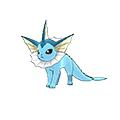

In [67]:
predict_image('test/vaporeon.jpg')
Image('test/vaporeon.jpg')

Expected Type: Others
Predict Type: Others


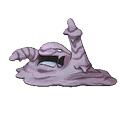

In [69]:
predict_image('test/muk.jpg')
Image('test/muk.jpg')